# Entrenamiento PM10 promedio móvil


Una vez que se tienen los datos limpios y procesados, estos pueden ser usados para la generación de los modelos. A continuación se muestra el flujo trabajo para la generación de los modelos:

<img src="./gen_modelos.png" style="height:300px">

Los modelos utilizados son del tipo __supervisado___, esto quiere decir que se necesita tener el valor real para poder generar los modelos, este valor corresponde a la columna del contaminante a pronosticar a una hora específica.  

Una vez que se tiene esta columna identificado, es necesario dividir los datos de entrenamiento en dos conjuntos: de __entrenamiento__ y __prueba__. La razón de dividirlos es para poder cuantiﬁcar el desempeño y el correcto funcionamiento de los modelos. El conjunto de entrenamiento correspondió al __80%__ de los datos totales y en éste se ejecutarán los modelos estadísticos para obtener los árboles de decisión y con el conjunto de prueba que correspondió al __20%__ restante, se comparará el pronóstico de los modelos con el valor real.

Con el conjunto de entrenamiento se ejecutaron todas las pruebas realizadas, aplicando los modelos de machine learning ya mencionados. Los modelos se optimizaron para tener un correcto pronóstico de valores alrededor del nivel de contaminación de la contingencia ambiental. Los modelos de los tres contaminantes son capaces de generar el pronóstico hasta de 24 horas, para cada hora se generó un modelo de manera que se generaron 24 modelos.


### Métricas de Valoración
Para medir el desempeño de un modelo de pronóstico es importante contar con una métrica de desempeño. Medir el desempeño del pronóstico es importante para saber que los métodos y características con los que trabaja el pronóstico son los adecuados. Además, calcular el desempeño de los modelos nos ayudará en la búsqueda de partes del pronóstico que no trabajen de manera óptima y con esto tomar decisiones para mejorar el desempeño del mismo. Las principales métricas usadas para medir el desempeño del modelo son el RMSE que nos indica qué tanto se aleja la predicción del valor real, la R2 que determina la calidad del modelo para replicar los resultados y la proporción de variación de los resultados que puede explicarse por el modelo y la precisión que nos indica cuántos falsos positivos genera el modelo es decir, cuántas contingencias son pronosticadas incorrectamente por cada contingencia pronosticada correctamente.


__Pasos y descripción general del notebook__


- __Datos recibidos:__ Limpieza de datos inicial
- __Responsable:__ Daniel Bustillos
- __Contacto:__  juandaniel.bucam@gmail.com


In [39]:
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_tree

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#import missingno as msn

pd.options.mode.chained_assignment = None 

from sklearn.externals import joblib
from xgboost.sklearn import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor 

from sklearn.datasets import make_regression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import fbeta_score, make_scorer

import seaborn as sn
from sklearn.metrics import confusion_matrix as confussion_matrix_function
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer

from sklearn.metrics import accuracy_score
from matplotlib import pyplot
# plot learning curve
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot
import seaborn as sns
import random as rd
import time

#### Hacemos una función para obtenner el -promedio- de los dos modelos

In [2]:
def predictor_mean(model0_1,modelo_2,X_set):  
    #aplicamos los predict
    forecast_q = model0_1.predict(X_set) 
    forecast = modelo_2.predict(X_set)
   #generamos una lista dummy: 
    forecast_mean = forecast 
    
    for i in range(len(X_set)):
        if  forecast[i] < 135:
            forecast_mean[i] = forecast[i]
        elif  forecast_q[i] > 160:
            forecast_mean[i] = forecast_q[i]
        if  130 < forecast_q[i] <155 and 130 < forecast[i] < 155:
            forecast_mean[i] = (0.3*forecast_q[i] + 0.7*forecast[i])
        if  140 < forecast_q[i] <160 and 140 < forecast[i] < 160:
            forecast_mean[i] = (forecast_q[i] + forecast[i])/2
    return forecast_mean

Definimos el score [specifity](https://es.wikipedia.org/wiki/Especificidad_(epidemiología)) que se basa en el número de **TP** por cada **FP + FN**.

 $$Especifity = \frac{TP}{FP + FN}$$

## Hacemos una función para graficar

In [3]:
def ploter(y_test_0,X_test_0,pronosticados_0,model):
    
    plt.scatter(y_test_0, pronosticados_0,alpha=0.5,color="royalblue")
    score = round(model.score(X_test_0, y_test_0),3)
    rmse = round(np.sqrt(mean_squared_error(y_test_0, pronosticados_0)),3)
    plt.plot([30,130],[30,130],color="k",linestyle='--')
    
    plt.axhline(y=150, color='k', linestyle='--')
    plt.axvline(x=150, color='k', linestyle='--')
    plt.annotate('TP', (170,150), xytext = (175, 155 + 1), 
                  horizontalalignment='right')
    plt.annotate('FN', (170,150), xytext = (175, 135 + 1), 
                  horizontalalignment='right')
    plt.annotate('FP', (170,150), xytext = (125, 155 + 1), 
                  horizontalalignment='right')
    plt.annotate('FP', (170,150), xytext = (125, 135 + 1), 
                  horizontalalignment='right')
    plt.annotate("Score ="+str(score), (15,139), xytext = (15, 139 + 1), 
                  horizontalalignment='left')
    plt.annotate("RMSE ="+str(rmse), (15,119), xytext = (15, 119 + 1), 
                  horizontalalignment='left')
    
    
    plt.xlabel('Measured')
    plt.ylabel('Predicted')
    plt.title('Pronóstico con Persistencia Temporal')
    plt.show()

## Cargamos los modelos ya entrenados:

In [4]:
conta = 'PM10mean'

In [5]:
model = [0 for col in range(25)]
modelq = [0 for col in range(25)]

#### Cargamos los datos:

In [6]:
data_hour_merge = pd.read_csv(str("/DATA/paw/jupyterhub_notebook/daniel.bustillos/DanielBustillos/"+
                                  "contaminación/pipeline_norberto_11horas/datos/datos_modelos_"+ conta +".csv"))

In [7]:
data_hour_merge['fecha'] = pd.to_datetime(data_hour_merge['fecha'], format='%Y-%m-%d %H:%M:%S')
data_hour_merge["hora"] = [row["fecha"].hour for index, row in data_hour_merge.iterrows()]

### Filtro de contingencia

In [8]:
data_hour_merge.loc[data_hour_merge["PM10mean_max_frcst_11"]>171.74, 'class'] = 1
data_hour_merge.loc[data_hour_merge["PM10mean_max_frcst_11"]<=171.74, 'class'] = 0

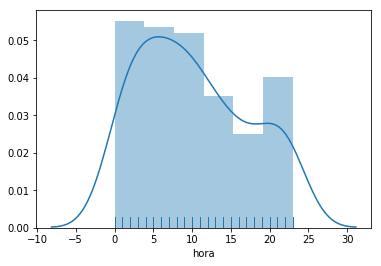

In [14]:
sns.distplot(data_hour_merge["hora"][data_hour_merge["class"]==1], kde=True, rug=True)

En contraste con la distriubción de precontingencias del Ozono, en el caso del PM10 y PM2.5, estas están distribuidas a lo largo del día, presumiblemente debido a que se considera el promedio móvil de las últimas 24 horas y no la medición puntual. 

> __Por este motivo vamos a hacer un 24 modelos, que pronostiquen a las 4am para cada hora del día.__

#### Filtramos por el día donnde se va a aplicar el pronóstico:

Definimos la lista de los targets:

### No aplica para PM10 o PM25
ya que la distribuciónn de contingencias es a lo largo del día

Borramos las columnas del target.

In [15]:
target = "PM10mean_max_frcst_"

lista = []
for i in range(1,25):
    lista.append(str(target+str(i)))

In [16]:
lista = []
for i in range(1,25):
    lista.append(str(target+str(i)))

In [17]:
conta = 'PM10mean'

## Training and verificationn split

Separamos en conjunto de verificacion y training según el anio:

In [18]:
data_hour_merge['fecha'] = pd.to_datetime(data_hour_merge['fecha'], format='%Y-%m-%d %H:%M:%S')
data_hour_merge["anio"] = [row["fecha"].year for index, row in data_hour_merge.iterrows()]
data_hour_merge["mes"] = [row["fecha"].month for index, row in data_hour_merge.iterrows()]

In [19]:
data_hour_merge_training = data_hour_merge[data_hour_merge["anio"].isin([2018, 2017,2016,2015])]
data_hour_merge_verification = data_hour_merge[data_hour_merge["anio"].isin([2019,])]

In [20]:
data_hour_merge_training.drop("fecha",axis=1,inplace=True)
data_hour_merge_verification.drop("fecha",axis=1,inplace=True)
data_hour_merge_training.drop("anio",axis=1,inplace=True)
data_hour_merge_verification.drop("anio",axis=1,inplace=True)

In [21]:
hora = 11
dataset = data_hour_merge_verification.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)
dataset.drop(lista[:],axis=1,inplace=True)

X_verification = dataset.loc[:, dataset.columns != "class"]
y_verification = dataset["class"]

In [22]:
del data_hour_merge_verification

In [23]:
del data_hour_merge

# Clasificador:

#### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [25]:
from sklearn.metrics import confusion_matrix as confussion_matrix_function
from sklearn.model_selection import GridSearchCV

In [26]:
hora = 11

dataset = data_hour_merge_training.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)
dataset.drop(lista[:],axis=1,inplace=True)

X = dataset.loc[:, dataset.columns != "class"]
y = dataset["class"]

#Definimos los conjuntos de prueba:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rd.randint(1,100))

In [55]:
model3= selection_model = XGBClassifier(
 n_estimators=550,
 max_depth=10,
 min_child_weight=2,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=2)
# eval model

In [56]:
eval_set = [(X_train, y_train), (X_test, y_test)]

In [57]:
model3.fit(X_train, y_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)

[0]	validation_0-error:0.002772	validation_0-logloss:0.599115	validation_1-error:0.005691	validation_1-logloss:0.599622
[1]	validation_0-error:0.002273	validation_0-logloss:0.522084	validation_1-error:0.005044	validation_1-logloss:0.523115
[2]	validation_0-error:0.001996	validation_0-logloss:0.457725	validation_1-error:0.004397	validation_1-logloss:0.458996
[3]	validation_0-error:0.002051	validation_0-logloss:0.403212	validation_1-error:0.004139	validation_1-logloss:0.404813
[4]	validation_0-error:0.001885	validation_0-logloss:0.356656	validation_1-error:0.004139	validation_1-logloss:0.358683
[5]	validation_0-error:0.001774	validation_0-logloss:0.3165	validation_1-error:0.003751	validation_1-logloss:0.318858
[6]	validation_0-error:0.001718	validation_0-logloss:0.281662	validation_1-error:0.003751	validation_1-logloss:0.284251
[7]	validation_0-error:0.001552	validation_0-logloss:0.251343	validation_1-error:0.004009	validation_1-logloss:0.254192
[8]	validation_0-error:0.001552	validation

[69]	validation_0-error:0.000111	validation_0-logloss:0.001868	validation_1-error:0.003233	validation_1-logloss:0.008957
[70]	validation_0-error:0.000111	validation_0-logloss:0.001804	validation_1-error:0.003233	validation_1-logloss:0.008885
[71]	validation_0-error:0.000111	validation_0-logloss:0.001737	validation_1-error:0.003104	validation_1-logloss:0.008804
[72]	validation_0-error:0.000111	validation_0-logloss:0.001667	validation_1-error:0.003104	validation_1-logloss:0.00869
[73]	validation_0-error:0.000111	validation_0-logloss:0.001612	validation_1-error:0.003233	validation_1-logloss:0.00862
[74]	validation_0-error:0.000111	validation_0-logloss:0.001561	validation_1-error:0.003104	validation_1-logloss:0.008547
[75]	validation_0-error:0.000111	validation_0-logloss:0.00151	validation_1-error:0.003104	validation_1-logloss:0.008484
[76]	validation_0-error:0.000111	validation_0-logloss:0.001468	validation_1-error:0.002975	validation_1-logloss:0.008399
[77]	validation_0-error:0.000111	va

[138]	validation_0-error:0	validation_0-logloss:0.000596	validation_1-error:0.00194	validation_1-logloss:0.006906
[139]	validation_0-error:0	validation_0-logloss:0.000591	validation_1-error:0.002069	validation_1-logloss:0.00694
[140]	validation_0-error:0	validation_0-logloss:0.000588	validation_1-error:0.002069	validation_1-logloss:0.006929
[141]	validation_0-error:0	validation_0-logloss:0.000584	validation_1-error:0.002199	validation_1-logloss:0.00691
[142]	validation_0-error:0	validation_0-logloss:0.00058	validation_1-error:0.002199	validation_1-logloss:0.00693
[143]	validation_0-error:0	validation_0-logloss:0.000576	validation_1-error:0.002199	validation_1-logloss:0.006913
[144]	validation_0-error:0	validation_0-logloss:0.000571	validation_1-error:0.002199	validation_1-logloss:0.006894
[145]	validation_0-error:0	validation_0-logloss:0.000567	validation_1-error:0.002199	validation_1-logloss:0.006895
[146]	validation_0-error:0	validation_0-logloss:0.000563	validation_1-error:0.002199	

[210]	validation_0-error:0	validation_0-logloss:0.000439	validation_1-error:0.002328	validation_1-logloss:0.006623
[211]	validation_0-error:0	validation_0-logloss:0.000438	validation_1-error:0.002328	validation_1-logloss:0.006654
[212]	validation_0-error:0	validation_0-logloss:0.000437	validation_1-error:0.002328	validation_1-logloss:0.00667
[213]	validation_0-error:0	validation_0-logloss:0.000437	validation_1-error:0.002328	validation_1-logloss:0.006677
[214]	validation_0-error:0	validation_0-logloss:0.000435	validation_1-error:0.002328	validation_1-logloss:0.006663
[215]	validation_0-error:0	validation_0-logloss:0.000434	validation_1-error:0.002328	validation_1-logloss:0.006659
[216]	validation_0-error:0	validation_0-logloss:0.000433	validation_1-error:0.002328	validation_1-logloss:0.006673
[217]	validation_0-error:0	validation_0-logloss:0.000432	validation_1-error:0.002328	validation_1-logloss:0.006672
[218]	validation_0-error:0	validation_0-logloss:0.000431	validation_1-error:0.002

[282]	validation_0-error:0	validation_0-logloss:0.000385	validation_1-error:0.002328	validation_1-logloss:0.006583
[283]	validation_0-error:0	validation_0-logloss:0.000384	validation_1-error:0.002328	validation_1-logloss:0.006589
[284]	validation_0-error:0	validation_0-logloss:0.000384	validation_1-error:0.002328	validation_1-logloss:0.006607
[285]	validation_0-error:0	validation_0-logloss:0.000383	validation_1-error:0.002328	validation_1-logloss:0.006589
[286]	validation_0-error:0	validation_0-logloss:0.000383	validation_1-error:0.002328	validation_1-logloss:0.006608
[287]	validation_0-error:0	validation_0-logloss:0.000382	validation_1-error:0.002328	validation_1-logloss:0.006601
[288]	validation_0-error:0	validation_0-logloss:0.000381	validation_1-error:0.002328	validation_1-logloss:0.006587
[289]	validation_0-error:0	validation_0-logloss:0.000381	validation_1-error:0.002328	validation_1-logloss:0.006595
[290]	validation_0-error:0	validation_0-logloss:0.00038	validation_1-error:0.002

[354]	validation_0-error:0	validation_0-logloss:0.000348	validation_1-error:0.002328	validation_1-logloss:0.006533
[355]	validation_0-error:0	validation_0-logloss:0.000348	validation_1-error:0.002328	validation_1-logloss:0.006528
[356]	validation_0-error:0	validation_0-logloss:0.000347	validation_1-error:0.002328	validation_1-logloss:0.00652
[357]	validation_0-error:0	validation_0-logloss:0.000346	validation_1-error:0.002328	validation_1-logloss:0.006512
[358]	validation_0-error:0	validation_0-logloss:0.000346	validation_1-error:0.002328	validation_1-logloss:0.006507
[359]	validation_0-error:0	validation_0-logloss:0.000346	validation_1-error:0.002328	validation_1-logloss:0.006529
[360]	validation_0-error:0	validation_0-logloss:0.000345	validation_1-error:0.002328	validation_1-logloss:0.006524
[361]	validation_0-error:0	validation_0-logloss:0.000345	validation_1-error:0.002328	validation_1-logloss:0.006515
[362]	validation_0-error:0	validation_0-logloss:0.000344	validation_1-error:0.002

[426]	validation_0-error:0	validation_0-logloss:0.000321	validation_1-error:0.002328	validation_1-logloss:0.006459
[427]	validation_0-error:0	validation_0-logloss:0.000321	validation_1-error:0.002328	validation_1-logloss:0.006464
[428]	validation_0-error:0	validation_0-logloss:0.000321	validation_1-error:0.002328	validation_1-logloss:0.006473
[429]	validation_0-error:0	validation_0-logloss:0.00032	validation_1-error:0.002328	validation_1-logloss:0.006463
[430]	validation_0-error:0	validation_0-logloss:0.00032	validation_1-error:0.002328	validation_1-logloss:0.006456
[431]	validation_0-error:0	validation_0-logloss:0.00032	validation_1-error:0.002328	validation_1-logloss:0.006463
[432]	validation_0-error:0	validation_0-logloss:0.000319	validation_1-error:0.002328	validation_1-logloss:0.006472
[433]	validation_0-error:0	validation_0-logloss:0.000319	validation_1-error:0.002328	validation_1-logloss:0.006465
[434]	validation_0-error:0	validation_0-logloss:0.000319	validation_1-error:0.00232

[498]	validation_0-error:0	validation_0-logloss:0.000302	validation_1-error:0.002328	validation_1-logloss:0.006395
[499]	validation_0-error:0	validation_0-logloss:0.000302	validation_1-error:0.002328	validation_1-logloss:0.006393
[500]	validation_0-error:0	validation_0-logloss:0.000302	validation_1-error:0.002328	validation_1-logloss:0.006396
[501]	validation_0-error:0	validation_0-logloss:0.000301	validation_1-error:0.002328	validation_1-logloss:0.006401
[502]	validation_0-error:0	validation_0-logloss:0.000301	validation_1-error:0.002328	validation_1-logloss:0.006415
[503]	validation_0-error:0	validation_0-logloss:0.000301	validation_1-error:0.002328	validation_1-logloss:0.006413
[504]	validation_0-error:0	validation_0-logloss:0.000301	validation_1-error:0.002328	validation_1-logloss:0.006428
[505]	validation_0-error:0	validation_0-logloss:0.000301	validation_1-error:0.002328	validation_1-logloss:0.006436
[506]	validation_0-error:0	validation_0-logloss:0.0003	validation_1-error:0.0023

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=10,
       min_child_weight=2, missing=None, n_estimators=550, n_jobs=1,
       nthread=4, objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=2, silent=None,
       subsample=0.8, verbosity=1)

In [58]:
def specifity(y_true_function,y_pred_function):
    
    """
    
    
    """
    try:
        tn, fp, fn, tp = confussion_matrix_function(y_true_function.tolist(), y_pred_function.tolist()).ravel()
        score = (tp*100) / (fn+(np.exp(fp)))
        return score
    except:
        return 0

 # score will negate the return value of my_custom_loss_func,
# which will be np.log(2), 0.693, given the values for X
# and y defined below.
specifity_scorer = make_scorer(specifity, greater_is_better=True)

Accuracy: 0


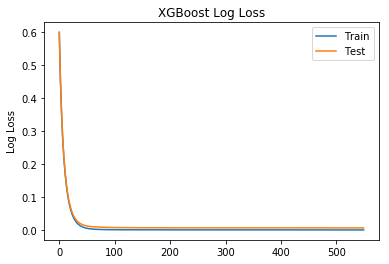

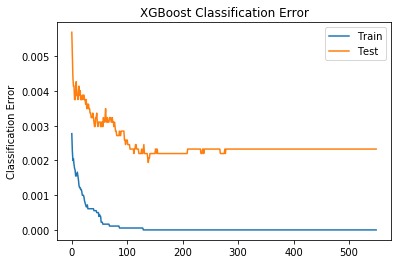

In [59]:
# make predictions for test data
y_pred = model3.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = specifity(predictions,y_test)
print("Accuracy: " +str(accuracy))
# retrieve performance metrics
results = model3.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)


# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()


# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

## GridSearch

## Plot

In [34]:
def model_specifity_ploter(df_specifity,score):
    """


    """

    #Gráficas
    specifity_test_plot = df_specifity.mean(axis=0).values
    df_specifity=df_specifity.T

    plt.subplots(figsize=(8, 3))
    plt.plot(values_search, specifity_test_plot,color="royalblue")
    plt.title(str(score))


  
    plt.tight_layout()
    plt.show() 

### Verification

In [35]:
def verification_model_score(
                            df,target,n_iteraciones,
                            iteraciones,n_iteracion):
    """
    
    
    """
    dataset = df.copy()
    #dataset.drop(["fecha"],axis=1,inplace=True)
    dataset.dropna(inplace=True)
    dataset.drop(lista[:],axis=1,inplace=True)

    X = dataset.loc[:, dataset.columns != target]
    y = dataset[target]

    #Definimos los conjuntos de prueba:

    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rd.randint(1,100))
    #Definimos los conjuntos de prueba:
    iteraciones = [entrada for entrada in range(n_iteraciones)] ##definimos el número de iteraciones
    
    df_confussion_test = pd.DataFrame(index=iteraciones, columns=["tn","fp","fn","tp"])
    df_confussion_mean_test = pd.DataFrame(index=[0,1], columns=[0,1])

    for iteracion in iteraciones:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rd.randint(1,100))
        model = XGBClassifier(params=parameters[n_iteracion])#definimos los parametros
        model_train = model.fit(X_train, y_train)#fit
        pred_test = model_train.predict(X_test)
        #confussion matrix
        df_confussion_test.iloc[iteracion,:] = confussion_matrix_function(y_test,pred_test).ravel()

    print(df_confussion_test)
    
    df_confussion_mean_test.iloc[0,:] = df_confussion_test.describe().iloc[1,0:2].values
    df_confussion_mean_test.iloc[1,:] = df_confussion_test.describe().iloc[1,2:4].values
    df_confussion_mean_test = df_confussion_mean_test.apply(pd.to_numeric, errors='ignore')

    sn.heatmap(df_confussion_mean_test, annot=True)

In [36]:
hora = 11

dataset = data_hour_merge_training.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)
dataset.drop(lista[:],axis=1,inplace=True)

X = dataset.loc[:, dataset.columns != "class"]
y = dataset["class"]

#Definimos los conjuntos de prueba:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rd.randint(1,100))

In [37]:
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█'):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix), end = '\r')
    # Print New Line on Complete
    if iteration == total: 
        print()

In [65]:
def xgboost_autoparameter_tunning(
                                df,target,parameter_grid,resamples,
                                parameters_list,score=specifity): 
    
    intentos = [number for number in range(resamples)]
    parameters_numbers_position = [i for i in range(len(parameters))]
    df_specifity = pd.DataFrame(columns=parameters_numbers_position,index=intentos)
    toolbar_width = len(intentos)
    
    
    ## progress bar 
    l = len(intentos)
    # Initial call to print 0% progress
    printProgressBar(0, l, prefix = 'Intentos:', suffix = '', length = 50)

    for intento in range(len(intentos)):
        
        X_training, X_testing, y_training, y_testing = train_test_split(X, y, test_size=0.3,   
                                                                        random_state=rd.randint(100,200)) 
        specifity_test_list = []# para cada conjunto de parametr

        for parameter_value in range(len(parameters_numbers_position)): ## iteramos sobre el parámetro deseado 

            model = XGBClassifier(**parameters[parameter_value])
            train_model = model.fit(X_training, y_training) ##model fit

            pred_test = train_model.predict(X_testing)  # predict verification

            specifity_test = specifity(y_testing,pred_test)## specifity model
            specifity_test_list.append(specifity_test)# specifity of search values and numbers
            
            
        time.sleep(0.1)
            # Update Progress Bar
        printProgressBar(intento + 1, l, prefix = 'Intentos:', suffix = '', length = 50)

            #print(specifity_test)
        specifity_test_list
        #print(df_specifity)

        df_specifity.loc[intento,:] = specifity_test_list
        
        
        
    df_specifity = df_specifity.apply(pd.to_numeric, errors = 'coerce')
    time.sleep(0)
    maximo = max(df_specifity.mean(axis=0))

    pos_maximum = [i for i,j in enumerate(df_specifity.mean(axis=0)) if j == maximo][0]
    maximo = round(maximo,2)

    #print(round(df_specifity.mean(axis=0),2))

    #print(df_confussion_mean)
    model_specifity_ploter(df_specifity,specifity)
    print()
    print("El máximo es para n="+ str(pos_maximum) + "  k=" + str(parameters[pos_maximum]) + 
          " con un " +"score"+"=  " +  str(maximo))

# booster

Intentos: |██████████████████████████████████████████████████| 100.0% Complete


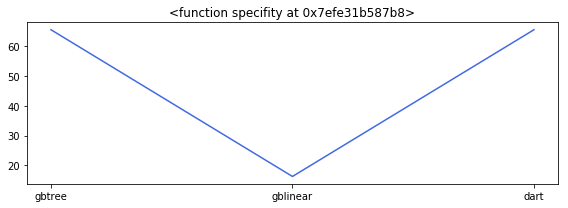


El máximo es para n=0  k={'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.01, 'max_delta_step': 0, 'max_depth': 10, 'n_estimators': 100, 'n_jobs': 100, 'nthread': None, 'objective': 'binary:logistic', 'verbosity': 1} con un score=  65.58


In [42]:
values_search=["gbtree","gblinear","dart"]
parameter_grid=values_search
parameters = [{ "booster":Serch_parameter, "colsample_bylevel":1,
 "colsample_bynode":1, "colsample_bytree":1, "gamma":0, "learning_rate":0.01,"max_delta_step":0, 
 "max_depth":10,"n_estimators":100, "n_jobs":100, "nthread":None,
 "objective":'binary:logistic', "verbosity":1} for Serch_parameter in parameter_grid]

xgboost_autoparameter_tunning(data_hour_merge_training,"class",parameter_grid,20,values_search)

Intentos: |██████████████████████████████████████████████████| 100.0% Complete


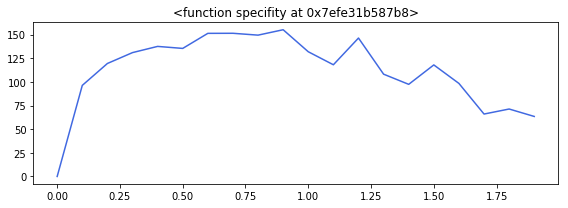


El máximo es para n=9  k={'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.9, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 0.95, 'missing': None, 'n_estimators': 65, 'n_jobs': 100, 'nthread': None, 'objective': 'binary:logitraw', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1} con un score=  155.07


In [44]:
values_search=[i/100 for i in range(0,200,10)]
parameter_grid=values_search
parameters = [{"base_score":0.5, "booster":'gbtree', "colsample_bylevel":1,
 "colsample_bynode":1, "colsample_bytree":1, "gamma":0, "learning_rate":Serch_parameter,"max_delta_step":0, 
 "max_depth":10, "min_child_weight":0.95, "missing":None,"n_estimators":65, "n_jobs":100, "nthread":None,
 "objective":'binary:logitraw', "random_state":0, "reg_alpha":0,
"reg_lambda":1, "scale_pos_weight":1, "seed":None, "silent":None,
"subsample":1, "verbosity":1} for Serch_parameter in parameter_grid]

xgboost_autoparameter_tunning(data_hour_merge_training,"class",parameter_grid,5,values_search)

## Verification

     tn  fp  fn  tp
0  7689   0   5  38
1  7680   1  17  34
2  7682   2  17  31
3  7687   1  16  28
4  7680   4   7  41
5  7684   1  13  34
6  7686   4  15  27
7  7691   0  11  30
8  7696   0  14  22
9  7689   0   5  38


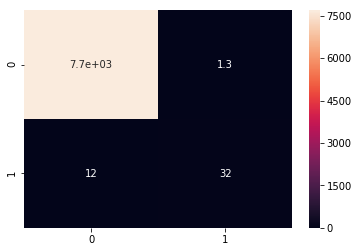

In [48]:
verification_model_score(data_hour_merge_training,"class",10,parameters,9)

### min_child_weight

Intentos: |██████████████████████████████████████████████████| 100.0% Complete


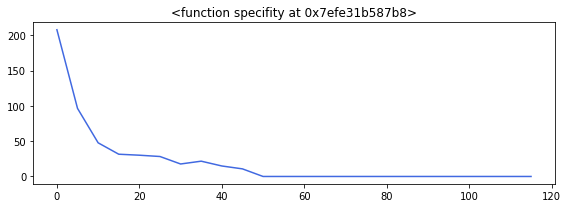


El máximo es para n=0  k={'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.9, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 0, 'missing': None, 'n_estimators': 65, 'n_jobs': 100, 'nthread': None, 'objective': 'binary:logitraw', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1} con un score=  207.81


In [51]:
parameter_grid=[i for i in range(0,120,5)]
values_search=parameter_grid
parameters = [{"base_score":0.5, "booster":'gbtree', "colsample_bylevel":1,
 "colsample_bynode":1, "colsample_bytree":1, "gamma":0, "learning_rate":0.9,"max_delta_step":0, 
 "max_depth":10, "min_child_weight":Serch_parameter, "missing":None,"n_estimators":65, "n_jobs":100, 
"nthread":None,"objective":'binary:logitraw', "random_state":0, "reg_alpha":0,
"reg_lambda":1, "scale_pos_weight":1, "seed":None, "silent":None,
"subsample":1, "verbosity":1} for Serch_parameter in parameter_grid]

xgboost_autoparameter_tunning(data_hour_merge_training,"class",parameter_grid,5,parameters)

      tn  fp  fn  tp
0   7682   2  17  31
1   7686   0  15  31
2   7682   0  18  32
3   7680   0  14  38
4   7682   0  18  32
5   7688   0  15  29
6   7684   0   8  40
7   7698   1   8  25
8   7679   4  17  32
9   7688   3   6  35
10  7696   1  11  24
11  7676   2  22  32
12  7686   0  15  31
13  7681   3  10  38
14  7683   0  15  34
15  7691   2  11  28
16  7677   0  23  32
17  7676   2  17  37
18  7685   1  12  34
19  7690   0  11  31
20  7688   3   6  35
21  7694   1  12  25
22  7680   2   8  42
23  7693   0  11  28
24  7684   0   8  40
25  7681   1   9  41
26  7684   1  15  32
27  7682   2  17  31
28  7681   0  10  41
29  7683   1  19  29


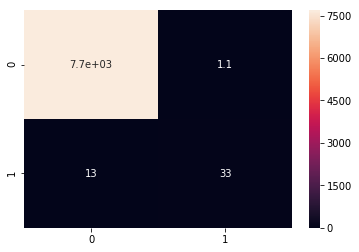

In [52]:
verification_model_score(data_hour_merge_training,"class",30,parameters,0)

### n_estimators

Intentos: |██████████████████████████████████████████████████| 100.0% Complete


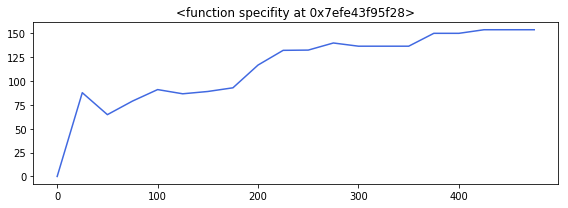


El máximo es para n=17  k={'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.03, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 0, 'missing': None, 'n_estimators': 425, 'n_jobs': 100, 'nthread': None, 'objective': 'binary:logitraw', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1} con un score=  153.73


In [60]:
parameter_grid=[i for i in range(0,500,25)]
values_search=parameter_grid
parameters = [{"base_score":0.5, "booster":'gbtree', "colsample_bylevel":1,
 "colsample_bynode":1, "colsample_bytree":1, "gamma":0, "learning_rate":0.03,"max_delta_step":0, 
 "max_depth":10, "min_child_weight":0, "missing":None,"n_estimators":Serch_parameter, "n_jobs":100, 
"nthread":None,"objective":'binary:logitraw', "random_state":0, "reg_alpha":0,
"reg_lambda":1, "scale_pos_weight":1, "seed":None, "silent":None,
"subsample":1, "verbosity":1} for Serch_parameter in parameter_grid]
xgboost_autoparameter_tunning(data_hour_merge_training,"class",parameter_grid,3,parameters)

In [41]:
verification_model_score(data_hour_merge_verification,"class",10,parameters,13)

IndexError: list index out of range

#### Gamma

Intentos: |██████████████████████████████████████████████████| 100.0% Complete


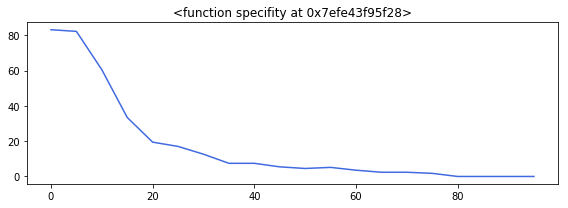


El máximo es para n=0  k={'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.03, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 0, 'missing': None, 'n_estimators': 100, 'n_jobs': 100, 'nthread': None, 'objective': 'binary:logitraw', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1} con un score=  83.09


In [62]:
parameter_grid=[i for i in range(0,100,5)]
values_search=parameter_grid
parameters = [{"base_score":0.5, "booster":'gbtree', "colsample_bylevel":1,
 "colsample_bynode":1, "colsample_bytree":1, "gamma":Serch_parameter, "learning_rate":0.03,"max_delta_step":0, 
 "max_depth":10, "min_child_weight":0, "missing":None,"n_estimators":100, "n_jobs":100, 
"nthread":None,"objective":'binary:logitraw', "random_state":0, "reg_alpha":0,
"reg_lambda":1, "scale_pos_weight":1, "seed":None, "silent":None,
"subsample":1, "verbosity":1} for Serch_parameter in parameter_grid]
xgboost_autoparameter_tunning(data_hour_merge_training,"class",parameter_grid,4,parameters)

      tn  fp  fn  tp
0   7688   0  15  29
1   7691   0  11  30
2   7685   0   7  40
3   7682   1  14  35
4   7677   2  20  33
5   7690   1   8  33
6   7673   2  15  42
7   7680   1  17  34
8   7696   0  14  22
9   7687   2  13  30
10  7682   0  18  32
11  7680   0  14  38
12  7682   2   8  40
13  7679   2  14  37


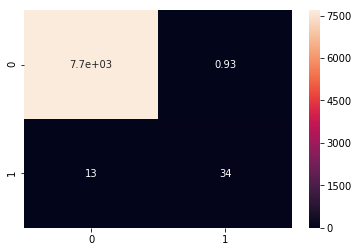

In [63]:
verification_model_score(data_hour_merge_training,"class",14,parameters,0)

## max_depth

Intentos: |██████████████████████████████████████████████████| 100.0% Complete


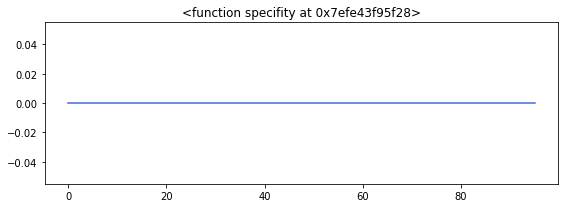


El máximo es para n=0  k={'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.03, 'max_delta_step': 0, 'max_depth': 0, 'min_child_weight': 56, 'missing': None, 'n_estimators': 65, 'n_jobs': 100, 'nthread': None, 'objective': 'binary:logitraw', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1} con un score=  0.0


In [64]:
parameter_grid=[i for i in range(0,100,5)]
values_search=parameter_grid
parameters = [{"base_score":0.5, "booster":'gbtree', "colsample_bylevel":1,
 "colsample_bynode":1, "colsample_bytree":1, "gamma":0, "learning_rate":0.03,"max_delta_step":0, 
 "max_depth":Serch_parameter, "min_child_weight":56, "missing":None,"n_estimators":65, "n_jobs":100, 
"nthread":None,"objective":'binary:logitraw', "random_state":0, "reg_alpha":0,
"reg_lambda":1, "scale_pos_weight":1, "seed":None, "silent":None,
"subsample":1, "verbosity":1} for Serch_parameter in parameter_grid]

xgboost_autoparameter_tunning(data_hour_merge_training,"class",parameter_grid,5,parameters)

     tn  fp  fn  tp
0  7682   1  14  35
1  7682   1  18  31
2  7686   0   7  39
3  7696   0  14  22
4  7690   0  16  26


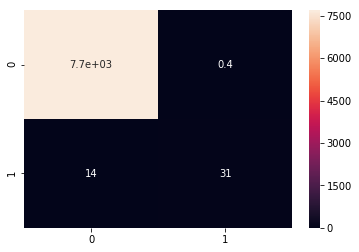

In [66]:
verification_model_score(data_hour_merge_training,"class",5,parameters,0)

## reg_alpha

Intentos: |██████████████████████████████████████████████████| 100.0% 


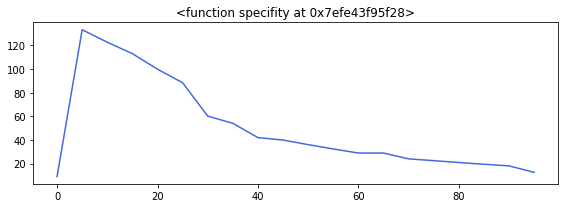


El máximo es para n=1  k={'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.03, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 0, 'missing': None, 'n_estimators': 100, 'n_jobs': 100, 'nthread': None, 'objective': 'binary:logitraw', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 5, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1} con un score=  133.33


In [80]:
parameter_grid=[i for i in range(0,100,5)]
values_search=parameter_grid
parameters = [{"base_score":0.5, "booster":'gbtree', "colsample_bylevel":1,
 "colsample_bynode":1, "colsample_bytree":1, "gamma":0, "learning_rate":0.03,"max_delta_step":0, 
 "max_depth":10, "min_child_weight":0, "missing":None,"n_estimators":100, "n_jobs":100, 
"nthread":None,"objective":'binary:logitraw', "random_state":0, "reg_alpha":0,
"reg_lambda":Serch_parameter, "scale_pos_weight":1, "seed":None, "silent":None,
"subsample":1, "verbosity":1} for Serch_parameter in parameter_grid]
xgboost_autoparameter_tunning(data_hour_merge_training,"class",parameter_grid,2,parameters)

     tn  fp  fn  tp
0  7685   2  13  32
1  7690   0  16  26
2  7686   0  15  31
3  7682   2  15  33
4  7684   0  17  31


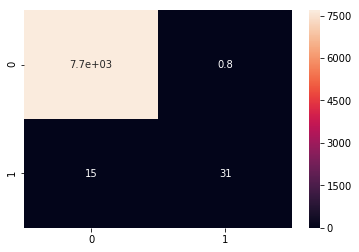

In [82]:
verification_model_score(data_hour_merge_training,"class",5,parameters,1)

### scale_pos_weight

Intentos: |██████████████████████████████████████████████████| 100.0% 


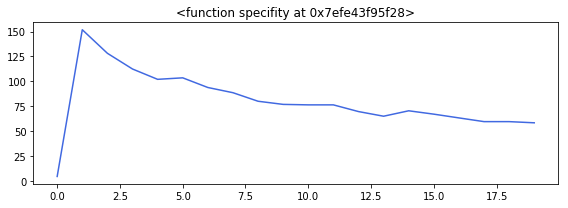


El máximo es para n=1  k={'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.03, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 0, 'missing': None, 'n_estimators': 100, 'n_jobs': 100, 'nthread': None, 'objective': 'binary:logitraw', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1} con un score=  151.79


In [77]:
parameter_grid=[i for i in range(0,20,1)]
values_search=parameter_grid
parameters = [{"base_score":0.5, "booster":'gbtree', "colsample_bylevel":1,
 "colsample_bynode":1, "colsample_bytree":1, "gamma":0, "learning_rate":0.03,"max_delta_step":0, 
 "max_depth":10, "min_child_weight":0, "missing":None,"n_estimators":100, "n_jobs":100, 
"nthread":None,"objective":'binary:logitraw', "random_state":0, "reg_alpha":0,
"reg_lambda":Serch_parameter, "scale_pos_weight":1, "seed":None, "silent":None,
"subsample":1, "verbosity":1} for Serch_parameter in parameter_grid]
xgboost_autoparameter_tunning(data_hour_merge_training,"class",parameter_grid,4,parameters)

     tn  fp  fn  tp
0  7689   0   5  38
1  7685   0   7  40
2  7693   3  10  26
3  7693   0  11  28
4  7691   0   9  32


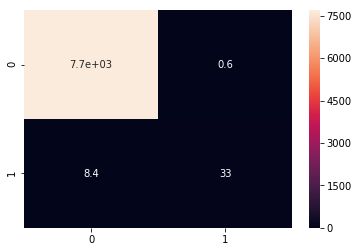

In [79]:
verification_model_score(data_hour_merge_training,"class",5,parameters,1)